<a href="https://colab.research.google.com/github/TheLemonPig/RL-SSM/blob/main/RL_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

There is some code hidden in folders in this notebook that need to be run but do not need to be looked inside for testing. It will be made clear which is which. These exist because I can't figure out how to make the repo this comes from something I can import into Google Colab.

## 1. Install Packages - run without opening

In [1]:
# # restart runtime after running and skip this cell
# !pip install 'pymc>=5.9'
# !pip install numpyro
# !pip install git+https://github.com/lnccbrown/hssm@main
# !pip install git+https://github.com/brown-ccv/hddm-wfpt@main

##2. Import Packages - run without opening

In [2]:
import numpyro
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import functools
from scipy.optimize import curve_fit
import pymc as pm
import arviz as az
from typing import List, Callable
from functools import partial
from tqdm import tqdm
import bambi as bmb
import itertools
import hddm_wfpt
import hssm

##3. Create Synthetic RL Model - run without opening

###3a. helper functions

In [3]:
def softmax(qs, tau):
  safe_tau = np.abs(tau) + 1e-2
  return np.exp(qs/safe_tau) / np.exp(qs/safe_tau).sum()

def rescola(qt, alpha, reward):
  return qt + alpha * (reward - qt)

In [4]:
class Distribution:

  def __init__(self, func: Callable, kwargs):
    self.func: Callable = partial(func, **kwargs)

  def __call__(self):
    return self.func.__call__()

seed = 0
np.random.seed(seed)
mean_rewards = [-1.0,1.0]
dists = [Distribution(np.random.normal,{"loc":mn, "scale":1.0}) for mn in mean_rewards]

In [211]:
dists

### 3b. Single participant RL model

In [237]:
class SimpleRL:

  def __init__(self, n_trials: int, distributions: List[Distribution]):
    self.n_choices: int = len(distributions)
    self.n_trials: int = n_trials
    self.distributions: List[Distribution] = distributions
    self.qs: np.array = np.ones((self.n_choices,)) * 0.5
    self.q_trace: np.array = np.ones((self.n_trials,self.n_choices))
    self.ps: np.array = np.ones((self.n_choices,)) / self.n_choices
    self.p_trace: np.array = np.zeros((self.n_trials, self.n_choices))
    self.rewards: np.array = np.zeros((self.n_trials))
    self.choices: np.array = np.zeros((self.n_trials),dtype=np.int32)

  def simulate(self, alpha, temperature):
    for i in range(self.n_trials):
      # Q-values are recorded to trace
      self.q_trace[i] = self.qs
      # softmax decision function
      self.ps = softmax(self.qs,temperature)
      self.p_trace[i] = self.ps
      # choice made based on weighted probabilities of Q-values
      choice = np.random.choice(a=self.n_choices,size=1,p=self.ps)[0]
      # choice is recorded to trace
      self.choices[i] = choice
      # reward calculated
      dist = self.distributions[choice]  # supply a list of distributions to choose from
      reward = dist()  # sample from distribution by calling it
      # Q-values updated
      self.rewards[i] = reward
      self.qs[choice] = rescola(self.qs[choice],alpha,reward)
    # Q-values trace returned
    # main data to be returned (basis for fits), is choices and rewards per trial
    return self.rewards, self.choices

### 3c. Test simple RL simulator

In [241]:
np.random.seed(0)
N_TRIALS = 100
rl_simulator = SimpleRL(n_trials = N_TRIALS, distributions = dists)
rl_simulator.simulate(alpha = 0.1, temperature = 0.5)

(array([ 1.74159174,  2.55291372,  0.15727595,  2.96992445,  2.26611853,
         0.49412346,  1.48431215,  1.57914048,  0.81841743,  2.41020463,
        -1.96075461,  1.37692697, -0.56349669,  0.43330238,  0.6669426 ,
         1.04736482,  1.56644004,  1.14926509,  2.78748405, -1.56951726,
        -0.0858006 ,  1.63973599,  1.99571135, -0.93320478,  0.86052604,
         0.80934402,  0.77406034, -0.65457077, -0.6886365 , -1.77602047,
         2.11971196, -1.45792242,  1.4253934 ,  0.97202882,  0.63566569,
         0.32122261,  0.32497817,  0.86721574,  1.17100044, -0.72567135,
         0.79357906,  1.48842647,  0.00909672,  2.01788005,  1.92525075,
         0.09521384,  2.84369153,  2.52550724,  0.92944277,  1.60415971,
         1.90751962,  0.41417713,  1.97359871,  1.20728277,  1.606389  ,
         1.00176084,  0.75892641,  1.05334491,  1.83771977, -0.49011141,
         1.60457228, -0.74305823,  2.29137792,  2.30069627,  0.03593664,
        -0.99077882,  0.41418482,  1.29877204,  0.9

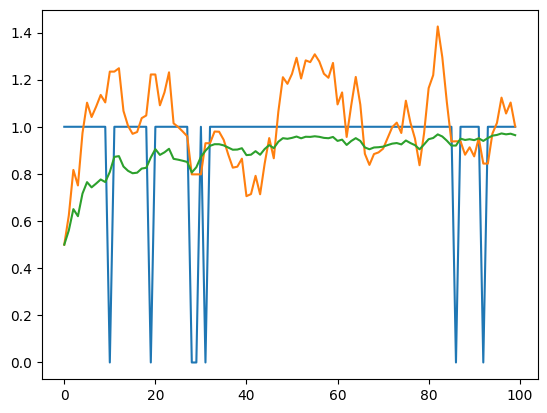

In [245]:
plt.plot(np.arange(N_TRIALS), rl_simulator.choices)
plt.plot(np.arange(N_TRIALS), rl_simulator.q_trace[:, 1])
plt.plot(np.arange(N_TRIALS), rl_simulator.p_trace[:, 1])

###3c. Multiple Participants RL Model

In [147]:
class MultiRL:

  def __init__(self, n_trials: int, n_participants: int, distributions: List[Distribution], debug_mode: bool = False, debug_random_seed: int = 0):
    self.participants: List[SimpleRL] = [
        SimpleRL(n_trials, distributions) for _ in range(n_participants)
    ]
    self.alphas = list()
    self.temperatures = list()
    self.debug_random_seed = debug_random_seed
    self.debug_mode = debug_mode

  def simulate(self, alpha_a, alpha_b, temperature_a, temperature_b):
    group_data = []
    for idx, participant_model in enumerate(self.participants):
      if self.debug_mode:
        np.random.seed(self.debug_random_seed)
      # sample participant parameters
      alpha = np.random.beta(alpha_a, alpha_b)
      temperature = np.random.beta(temperature_a, temperature_b)
      self.alphas.append(alpha)
      self.temperatures.append(temperature)
      participant_rewards, participants_choices = np.vstack(participant_model.simulate(alpha, temperature))
      assert sum(np.isnan(participant_rewards)) == 0, participant_rewards
      trial_col = np.arange(participant_model.n_trials).reshape((-1,1))
      idx_col = np.ones_like(trial_col) * idx
      group_data.append(np.concatenate([idx_col,participant_rewards.reshape((-1,1)),participants_choices.reshape((-1,1)),trial_col],axis=1))
    return np.concatenate(group_data)

  def get_params(self):
    return self.alphas, self.temperatures


## 5. Create PyMC Model

### 5a. Create Synthetic Data using Synthetic Model - these cells are really important for formatting

#### 5ai. simulate model - I would run without looking and look into the output data directly if you have any concerns

In [365]:
n_trials = 50
n_participants = 100
n_choices = len(dists)
multi_rl_model = MultiRL(n_trials=n_trials,n_participants=n_participants,distributions=dists)
data = multi_rl_model.simulate(alpha_a=10.0,alpha_b=10.0,temperature_a=10.,temperature_b=2.0)

In [366]:
df = pd.DataFrame(data=data,columns=['participant_id','rewards','choices','trial'])
df['rt'] = 0
df['response'] = 0
n_participants = len(df['participant_id'].unique())
C = np.array(df['choices'],dtype=np.int32)
C_onehot = np.array(np.eye(n_choices)[C],dtype=np.int32)
df['choice_0'] = C_onehot[:,0]
df['choice_1'] = C_onehot[:,1]
#df['choices']
df['participant_id_int'] = df['participant_id'].apply(lambda x: int(x))
df['n_participants'] = df['participant_id_int'].max() + 1
df['participant_id'] = df['participant_id_int'].apply(lambda x: str(x))

### 5b. Create wrapper loglikelihood functions - these cells are really important (most likely to have the error)

#### 5bi. Wrapper for first likelihood function

IMPORTANT OPTION TOGGLE INSIDE!!

- The first function header is required to compile the model outside of pymc/hssm

- The second function header is required to compile inside of hssm

This is because the function doesn't currently call data and so it will not compile with it as an argument in the header

Within this wrapper, there are 4 main preprocessing steps:
  1. Parameter values the number of participants, trials, and trials are calculated (or hard coded for now)
  2. ALL variables taken into the function are reshaped
    - from: (n_participants * n_trials,)
    - to: (n_participants , n_trials)
  3. the maximum value for each participant is taken from the reshaped alphas and betas - reshaping
    - from: (n_participants , n_trials)
    - to: (n_participants,)
  4. Reward and Choice vectors are repeated/stacked respectively into three dimensional tensors of shape (n_participants , n_trials, n_choices)

In [367]:
# parameters & variables
CM = pt.itensor3("CM") # choice matrices OVER PARTICIPANTS
RM = pt.dtensor3("RM") # reward matrices OVER PARTICIPANTS
# QM = pt.dmatrix("QM") # empty vectors to store q-values across trials OVER PARTICIPANTS
A = pt.dmatrix("A") # scalars of learning rates OVER PARTICIPANTS
B = pt.dmatrix("B") # scalars of RL decision temperatures OVER PARTICIPANTS
# mll = pt.dvector("mll")  # empty scalars to store ll value OVER PARTICIPANTS

def my_mll2_func(CM, RM, A, B):

    # function for a single RL step
    # updates Q-value for observed choice/feedback pair
    # for each participant/subject

    # C: vector (participants, choices) [observed choices]
    # R: vector (participants, choices) [observed reward/feedback]
    # Q_tm1: matrix (participants, choices) [current q-value state]
    # A: vector (participants, choices) [learning rate by participant]
    # def rl_step(C, R, A, Q_tm1):
    #     # print(A.eval().shape)
    #     # print(C.eval().shape)
    #     return Q_tm1 + pt.mul(A, pt.mul(C, (R - Q_tm1)))

    def rl_step(C, R, A, Q_tm1):
        return Q_tm1 + pt.mul(A, pt.mul(C, (R - Q_tm1)))

    ### function to calculate log-likelihood for each trial
    # C: matrix (participants, choices)
    # Qs: matrix (participants, choices)
    # B: vector (participants, choices)
    ## Ps: matrix
    ## P_select: vector
    # mll: vector
    # def ll_def(C, Qs, B, mll):
    #     denom = pt.exp(pt.true_div(Qs, B)).sum(axis=1)
    #     denom = pt.repeat(denom.reshape((denom.shape[0], 1)),n_choices, axis=1)
    #     Ps = pt.true_div(
    #          pt.exp(pt.true_div(Qs, B)),
    #          denom
    #          )
    #     P_select = pt.mul(Ps, C).sum(axis=1)  # pick out probability of selected option (via C)
    #     mll = pt.log(P_select)
    #     return mll

    def ll_def(C, Qs, B, mll):
        numerator = pt.exp(pt.true_div(Qs, B))
        denominator = numerator.sum(axis=1)
        # Good to get rid of the explicit denom.shape[0] below
        denominator = pt.repeat(denominator.reshape((denominator.shape[0], 1)), n_choices, axis=1)
        
        Ps = pt.true_div(
             numerator,
             denominator
             )
        P_select = pt.mul(Ps, C).sum(axis=1)  # pick out probability of selected option (via C)
        mll = pt.log(P_select)
        return mll

    n_choices = CM.shape[-1]
    n_participants = A.shape[1]
    mll = pt.zeros((n_participants), dtype='float64')
    # Resolve .scan complaint about extra dimensions in outputs_info (should be one leading dim more than results)
    #mll = pt.zeros((1, n_participants), dtype='float64')
    QM = pt.ones((n_participants, n_choices), dtype='float64') * 0.5
    # Resolve .scan complaint about extra dimensions in outputs_info (should be one leading dim more than results)
    #QM = pt.ones((n_participants, n_choices), dtype='float64') * 0.5

    # RM = pt.mul(RM,pt.ones_like((QM.shape[0])))

    # Bring Learning rate and temperature parameters
    # into shape useful for computations
    A = A.reshape((A.shape[0], A.shape[1], 1))
    B = B.reshape((B.shape[0], B.shape[1], 1))
    AM = pt.repeat(A,n_choices,axis=2)
    BM = pt.repeat(B,n_choices,axis=2)

    ### scan function
    # CM: tensor3 [matrix] (trials,[participants, choices])
    # RM: tensor3 [matrix] (trials,[participants, choices])
    # A: matrix (participants, choices)
    # QM: matrix (participants, choices) --> tensor3 (trials, participants, choices)
    #QsT3, updates = pytensor.scan(rl_step, sequences=[CM, RM, AM], non_sequences = [], outputs_info=QM)
    QsT3, updates = pytensor.scan(rl_step, sequences=[CM, RM, AM], non_sequences=[], outputs_info=QM)


    ### scan function
    # CM: tensor3 [matrix] (trials,[participants, choices])
    # QsT3: tensor3 [matrix] (trials, [participants, choices])
    # B: matrix (participants, choices)
    # mll: scalar --> vector
    # loglikes, updates = pytensor.scan(ll_def, sequences=[CM, QsT3, BM], non_sequences=[], outputs_info=mll)
    loglikes, updates = pytensor.scan(ll_def, sequences=[CM, QsT3, BM], non_sequences=[], outputs_info=mll)
    return loglikes

output = my_mll2_func(CM, RM, A, B)

mloglike_func2 = pytensor.function(inputs=[CM,RM,A,B],
                                   outputs=output)

In [368]:
def my_hdll(alphas, betas, choice_0, choice_1, rewards, n_participants, n_trials, n_choices):
#def my_hdll(data, alphas, betas, choice_0, choice_1, rewards,participants):
    R = rewards

    # IT TURNS OUT YOU NEED TO COMMENT THESE OUT FOR PYMC
    shaped_alphas = alphas.reshape((n_trials,n_participants)) # reshape((n_participants,n_trials)).dimshuffle([1,0])
    shaped_betas = betas.reshape((n_trials,n_participants)) # reshape((n_participants,n_trials)).dimshuffle([1,0])
    choice_0 = choice_0.reshape((n_trials,n_participants))  # reshape((n_participants,n_trials)).dimshuffle([1,0])
    choice_1 = choice_1.reshape((n_trials,n_participants))  # reshape((n_participants,n_trials)).dimshuffle([1,0])
    Cs = pt.stack([choice_0,choice_1], axis=-1)

    R = R.reshape((n_trials, n_participants, 1))  # reshape((n_participants,n_trials)).dimshuffle([1,0])
    RM = pt.repeat(R, n_choices, axis=-1) # RM --> (n_trials, n_participants, n_choices)
    CM = Cs

    return my_mll2_func(CM,RM,shaped_alphas,shaped_betas).flatten()

#### 5bii. Wrapper for second likelihood function

IMPORTANT OPTION TOGGLE INSIDE!!

This function is identical to the one above except step 3 is skipped and the variables are instead passed to the second likelihood function

### 5c. Make PyMC model

In [ ]:
# We can essentially decide, sorting has an effect 
# on whether we need dimshuffle in the likelihood

# The way the likelihood is set up right now, 
# expects the dataframe to be sorted by trial first

# If one sorts by participant_id, the likelihood should use dimshuffle

# The basic logic is that reshape fills in from the last dim!

# One can test this more later
df_model = df.sort_values(['trial', 'participant_id_int'])


# Make coordinates
participant_ids, participants = pd.factorize(df_model['participant_id'])
coords = {
          "participant_idx": np.array(participants),
          # "participant_idx": np.arange(len(participant_ids)),
          "obs_idx": np.arange(df_model.shape[0])
         }

In [369]:
with pm.Model(coords=coords) as hierarchical_model:
    # Data
    CM1 = pm.ConstantData('myCM', df_model['choice_0'].values)  # df['choice_0']
    CM2 = pm.ConstantData('myCM2', df_model['choice_1'].values)  # df['choice_1']
    RM = pm.ConstantData('myRM', df_model['rewards'])   # df['rewards']
    Nparticipants = pm.ConstantData('Nparticipants', (df_model['participant_id_int'].max() + 1).astype(int))  # df['participant_id']
    Nchoices = pm.ConstantData('Nchoices', np.int64(df_model['choices'].unique().shape[0]))
    Ntrials = pm.ConstantData('Ntrials', (df_model['trial'].max() + 1).astype(int))

    # Hyperpriors for group nodes
    alpha_a = pm.Gamma("alpha_a", alpha = 3. , beta = 3.)
    alpha_b = pm.Gamma("alpha_b", alpha = 3. , beta = 3.)
    beta_a = pm.Gamma("beta_a", alpha = 3. , beta = 3.)
    beta_b = pm.Gamma("beta_b", alpha = 3. , beta = 3.)

    # Priors for alphas and betas
    A = pm.Beta(name="A", alpha=alpha_a, beta=alpha_b, dims="participant_idx")
    B = pm.Beta(name="B", alpha=beta_a, beta=beta_b, dims="participant_idx")

    # Render parameters trial wise
    A_trial = A[participant_ids]
    B_trial = B[participant_ids] 

    # CHOOSE WHICH WRAPPER FUNCTION TO USE HERE
    pm.Potential("likelihood", my_hdll(A_trial, B_trial, CM1, CM2, RM, Nparticipants, Ntrials, Nchoices))
    idata_pooled = pm.sample(500, tune=500, chains=1, nuts_sampler="numpyro")

Compiling...
Compilation time = 0:00:04.074361
Sampling...
sample: 100%|██████████| 1000/1000 [01:49<00:00,  9.12it/s, 255 steps of size 2.03e-02. acc. prob=0.97]
Sampling time = 0:01:50.305475
Transforming variables...
Transformation time = 0:00:00.085988


In [370]:
df_summary = az.summary(idata_pooled)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


(array([ 2.,  3.,  8., 19., 18., 20., 17.,  7.,  4.,  2.]),
 array([0.23606496, 0.28916087, 0.34225678, 0.39535269, 0.4484486 ,
        0.50154451, 0.55464041, 0.60773632, 0.66083223, 0.71392814,
        0.76702405]),
 [<matplotlib.patches.Polygon at 0x7f773d708ad0>])

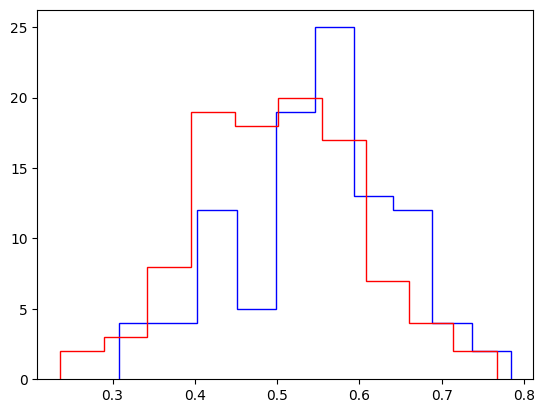

In [371]:
plt.hist(df_summary[df_summary.index.str.contains('A\[')]['mean'].values, histtype='step', color = 'blue')
plt.hist(multi_rl_model.alphas, histtype='step', color = 'red')

In [345]:
with pm.Model(coords=coords) as unpooled:
    # Data
    CM1 = pm.ConstantData('myCM', df_model['choice_0'].values)  # df['choice_0']
    CM2 = pm.ConstantData('myCM2', df_model['choice_1'].values)  # df['choice_1']
    RM = pm.ConstantData('myRM', df_model['rewards'])   # df['rewards']
    Nparticipants = pm.ConstantData('Nparticipants', (df_model['participant_id_int'].max() + 1).astype(int))  # df['participant_id']
    Nchoices = pm.ConstantData('Nchoices', np.int64(df_model['choices'].unique().shape[0]))
    Ntrials = pm.ConstantData('Ntrials', (df_model['trial'].max() + 1).astype(int))

    # Hyperpriors for group nodes
    # alpha_a = pm.Gamma("alpha_a", alpha = 3. , beta = 3.)
    # alpha_b = pm.Gamma("alpha_b", alpha = 3. , beta = 3.)
    # beta_a = pm.Gamma("beta_a", alpha = 3. , beta = 3.)
    # beta_b = pm.Gamma("beta_b", alpha = 3. , beta = 3.)

    # Priors for alphas and betas
    A = pm.Beta(name="A", alpha=1., beta=1., dims="participant_idx")
    B = pm.Beta(name="B", alpha=1., beta=1., dims="participant_idx")

    # Render parameters trial wise
    A_trial = A[participant_ids]
    B_trial = B[participant_ids] 

    # CHOOSE WHICH WRAPPER FUNCTION TO USE HERE
    pm.Potential("likelihood", my_hdll(A_trial, B_trial, CM1, CM2, RM, Nparticipants, Ntrials, Nchoices))
    idata_unpooled = pm.sample(500, tune=500, chains=1, nuts_sampler="numpyro")

Compiling...
Compilation time = 0:00:02.418768
Sampling...
sample: 100%|██████████| 1000/1000 [00:16<00:00, 60.99it/s, 31 steps of size 1.84e-01. acc. prob=0.90]
Sampling time = 0:00:16.910389
Transforming variables...
Transformation time = 0:00:00.049887


In [347]:
df_summary = az.summary(idata_unpooled)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


(array([ 2.,  1.,  3.,  7., 14.,  4., 13., 13., 19., 24.]),
 array([0.44390244, 0.49935049, 0.55479854, 0.6102466 , 0.66569465,
        0.7211427 , 0.77659076, 0.83203881, 0.88748687, 0.94293492,
        0.99838297]),
 [<matplotlib.patches.Polygon at 0x7f77a841b7d0>])

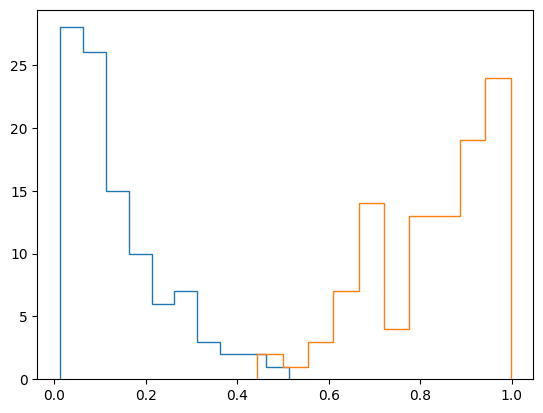

In [210]:
plt.hist(df_summary[df_summary.index.str.contains('A\[')]['mean'].values, histtype='step')
plt.hist(multi_rl_model.alphas, histtype='step')

In [182]:
az.summary(idata_mh).iloc[:20]

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_a,0.207,0.075,0.101,0.354,0.017,0.012,18.0,83.0,NaN
alpha_b,2.800,0.851,1.296,4.497,0.083,0.059,101.0,291.0,NaN
beta_a,2.359,0.512,1.494,3.360,0.043,0.030,145.0,318.0,NaN
beta_b,2.962,0.937,1.058,4.463,0.194,0.139,22.0,21.0,NaN
A[0],0.159,0.070,0.051,0.297,0.016,0.012,22.0,28.0,NaN
A[1],0.087,0.053,0.000,0.179,0.007,0.005,61.0,147.0,NaN
A[2],0.113,0.060,0.018,0.221,0.011,0.008,38.0,39.0,NaN
A[3],0.006,0.013,0.000,0.030,0.001,0.001,96.0,189.0,NaN
A[4],0.051,0.044,0.000,0.129,0.004,0.003,87.0,72.0,NaN
A[5],0.112,0.046,0.047,0.207,0.009,0.006,37.0,40.0,NaN


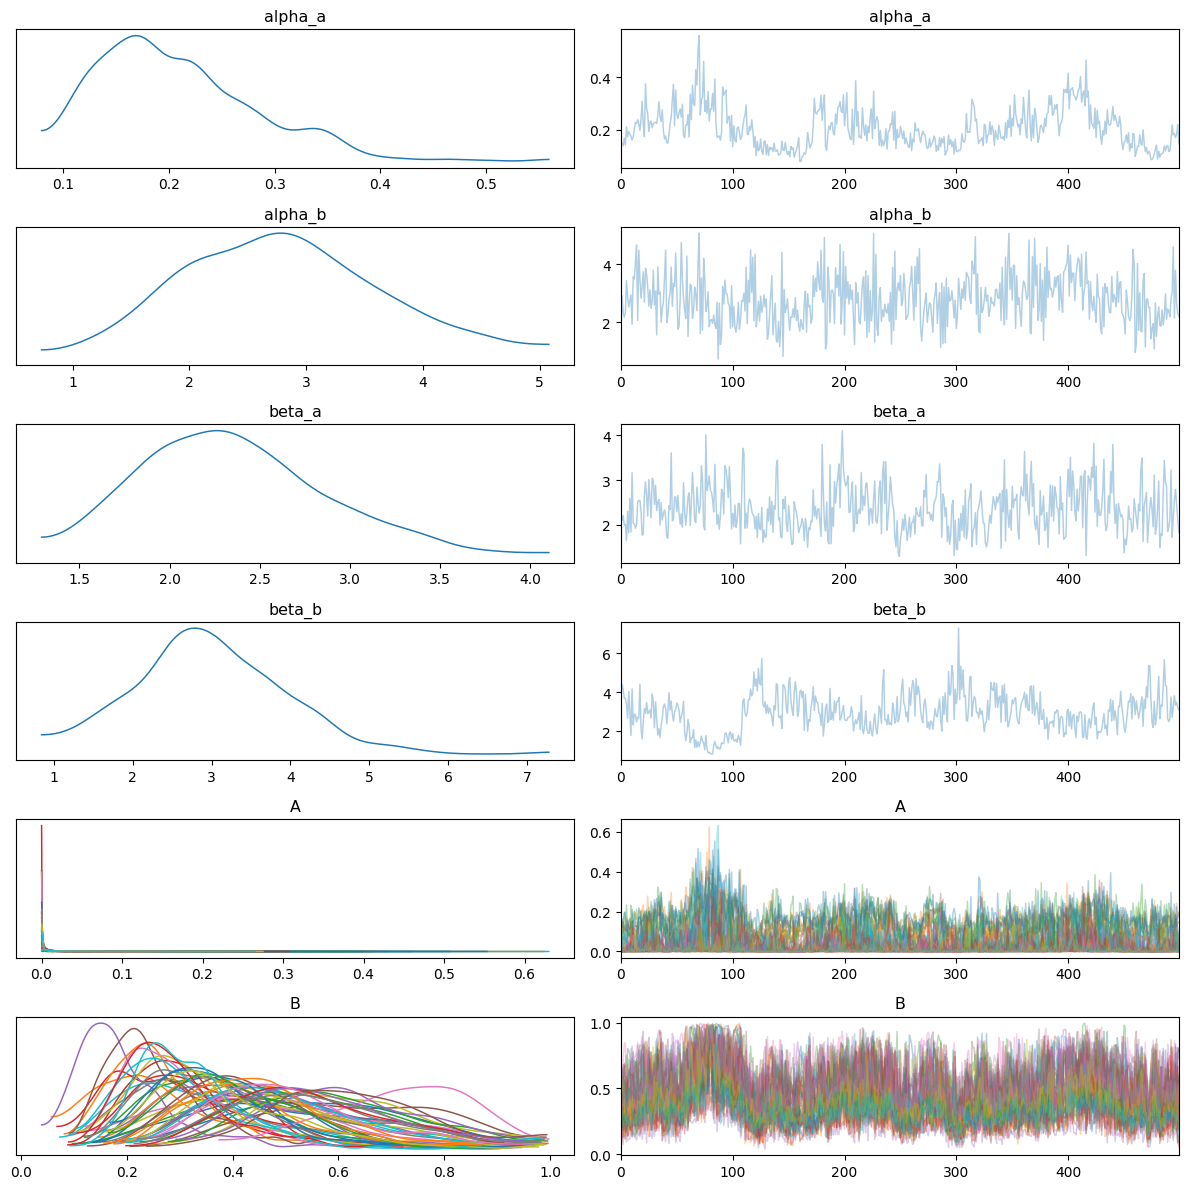

In [184]:
pm.plot_trace(idata_mh)
plt.tight_layout()

#### Testing pytensor reshape behavior

In [ ]:
a = pt.dvector('a')
n = pt.scalar('n', dtype='int64')
m = pt.scalar('m', dtype='int64')
def pt_reshape(pt_vec, n, m):
    return pt_vec.reshape((n , m)) # .dimshuffle([1, 0])
    
b = pt_reshape(a, n, m)
my_test_func = pytensor.function([a, n, m], [b])# .dimshuffle


# Make a dataframe for testing
my_a = np.tile(np.arange(5), (10,))
my_b = np.repeat(np.arange(10), 5)
my_df = pd.DataFrame(np.stack([my_a, my_b], axis = 1), columns = ['n_trial', 'n_participant'])
my_df = my_df.sort_values('n_trial')

my_test_out = my_test_func(my_df['n_trial'].values, 5, 10)

## 6. Integrate with HSSM - here for convenience (delete if needed)

I left this here for convenience sake

In [ ]:
def make_generalized_sigmoid_simple(a,b):
    def invlink_(x):
        return a + ((b - a) / (1 + pt.exp(-x)))
    return invlink_

def make_generalized_logit_simple(a,b):
    def link_(x):
        return pt.log((x - a) / (b - x))
    return link_

def build_generalized_sigmoid_links_simple(a,b):
    invlink_ = make_generalized_sigmoid_simple(a,b)
    link_ = make_generalized_logit_simple(a,b)
    return {'name': 'generalized_logit',
            'link': link_,
            'linkinv': invlink_,
            'linkinv_backend': invlink_}

In [ ]:
model_config_hier={
        "list_params": ["alphas", "betas"],
        "bounds": {
            "alphas": (0,1),
            "betas": (0.1,1),
        },
        "extra_fields": ['choice_0','choice_1','rewards','n_participants'],
        "backend": "numpyro"
    }
model = hssm.HSSM(
    data=hier_data,
    model="rl",
    hierarchical=False,
    loglik=my_hdll,
    loglik_kind="approx_differentiable",
    # analytical
    model_config=model_config_hier,
    include = [
                    {
                        "name": "alphas",
                        "formula": "alphas ~ 1 + (1|participant_id)", # + (1|participant_id)
                        "link": bmb.Link(**build_generalized_sigmoid_links_simple(model_config_hier['bounds']['alphas'][0],model_config_hier['bounds']['alphas'][1])),
                    },
                    {
                        "name": "betas",
                        "formula": "betas ~ 1 + (1|participant_id)",
                        "link": bmb.Link(**build_generalized_sigmoid_links_simple(model_config_hier['bounds']['betas'][0],model_config_hier['bounds']['betas'][1])),
                    }
    ],
    #"extra_namespace":
    #bmb.Prior("Uniform", lower=0.0, upper=1.0, initval=0.1),
)
sample = model.sample()
#%debug sample = model.sample()